In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
# Defining the Image size, Batch size, Color Channels, Epochs to be used later
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
# Using API to load all images in tensorflow dataset

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [4]:
# All the class names in dataset
class_names = dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy']

In [5]:
len(dataset)

313

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[6 4 1 8 6 2 3 6 9 2 9 1 0 1 8 5 6 5 4 1 4 1 1 2 7 6 9 9 8 1 4 0]


Visualize some of the Images from the Dataset

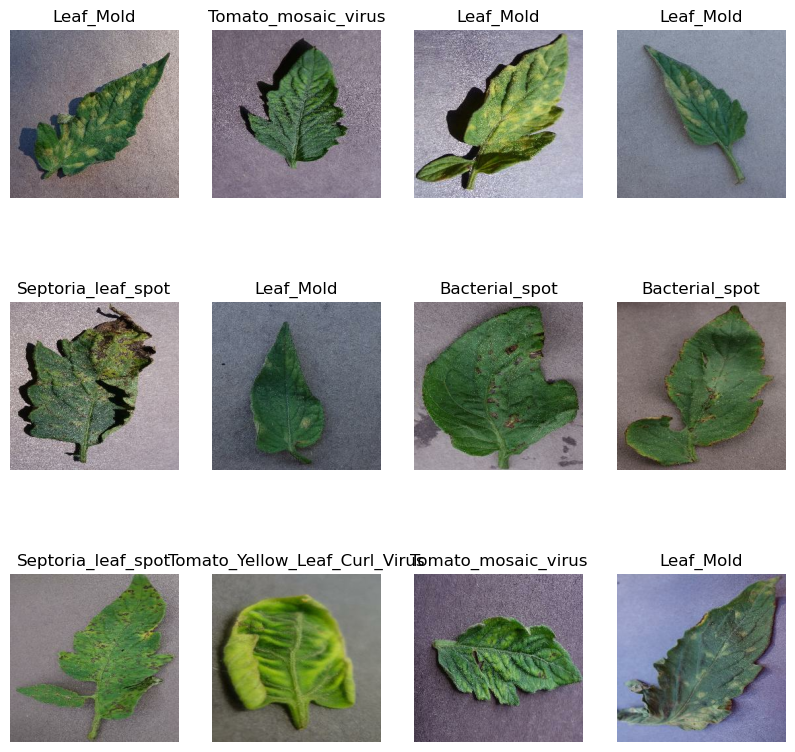

In [7]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Splitting Dataset and Creating Model

80% ==> Training, 
20% ==> 10% Validation, 10% ==> Testing


In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [10]:
len(train_ds)

250

In [11]:
len(val_ds)

31

In [12]:
len(test_ds)

32

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

# Model Architecture


In [16]:
# Building CNN Model and Training it

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape = input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

# Compiling the Model

In [18]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)



In [19]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
250/250 [==============================] - 251s 975ms/step - loss: 2.0368 - accuracy: 0.2276 - val_loss: 1.6006 - val_accuracy: 0.4536
Epoch 2/10
250/250 [==============================] - 199s 795ms/step - loss: 1.3658 - accuracy: 0.5068 - val_loss: 1.8602 - val_accuracy: 0.4103
Epoch 3/10
250/250 [==============================] - 229s 918ms/step - loss: 1.0108 - accuracy: 0.6378 - val_loss: 1.6112 - val_accuracy: 0.5060
Epoch 4/10
250/250 [==============================] - 223s 890ms/step - loss: 0.8424 - accuracy: 0.6906 - val_loss: 1.0472 - val_accuracy: 0.6482
Epoch 5/10
250/250 [==============================] - 232s 930ms/step - loss: 0.7043 - accuracy: 0.7431 - val_loss: 0.8761 - val_accuracy: 0.7117
Epoch 6/10
250/250 [==============================] - 262s 1s/step - loss: 0.6156 - accuracy: 0.7783 - val_loss: 1.0703 - val_accuracy: 0.6522
Epoch 7/10
250/250 [==============================] - 265s 1s/step - loss: 0.5521 - accuracy: 0.7988 - val_loss: 0.9563 - val_a

In [20]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 14s 242ms/step - loss: 0.8095 - accuracy: 0.7373


In [21]:
# Accuracy about 88 Percent
scores

[0.8094502687454224, 0.7373046875]

# Plotting the Accuracy and Loss Curves


In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 250}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
type(history.history['loss'])

list

In [26]:
len(history.history['loss'])

10

In [27]:
 
# show loss for first 5 epochs
history.history['loss'][:5]

[2.036776065826416,
 1.3657673597335815,
 1.0108002424240112,
 0.8423646688461304,
 0.7043112516403198]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Plotting the Training and Validation Accuracy

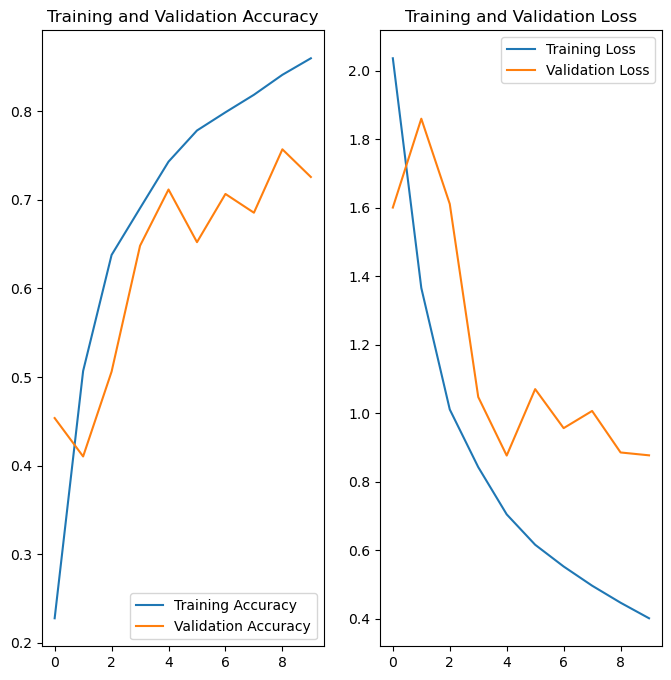

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run Prediction on a Sample Image

First Image to predict
Actual Label:  Septoria_leaf_spot
1/1 [==============================] - 0s 334ms/step
Predicted Label:  Septoria_leaf_spot


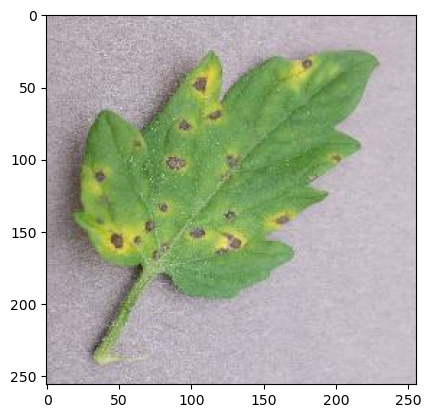

In [30]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])

    batch_pred = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_pred[0])])

Function for Inference

In [31]:
def predict(model, img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


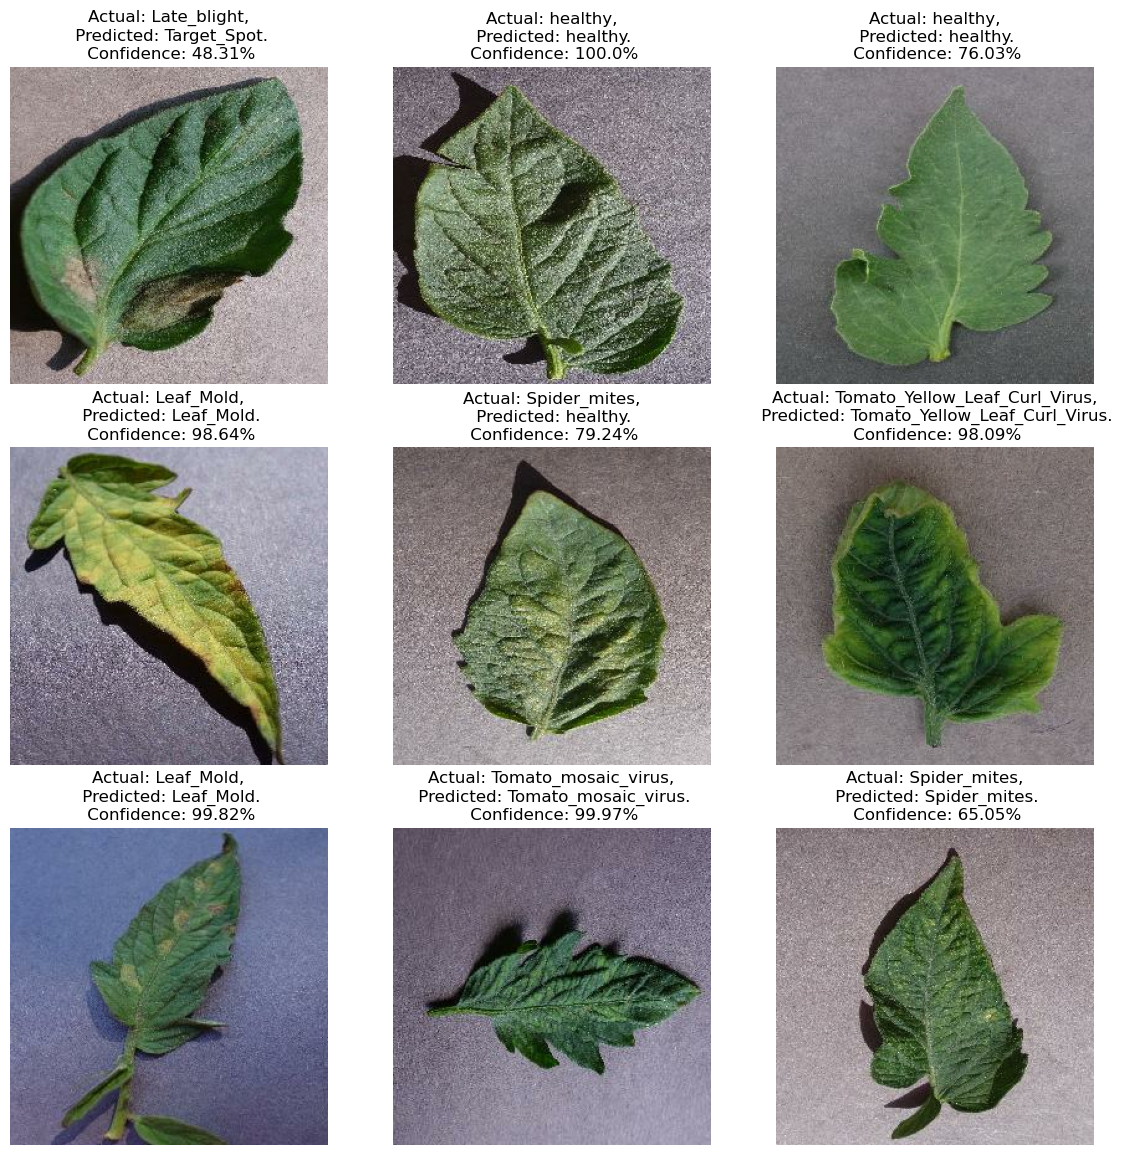

In [38]:
plt.figure(figsize=(14, 14))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [44]:
import os
model_version=1
model.save(f"./Models/1")



INFO:tensorflow:Assets written to: ./Models/1/assets


INFO:tensorflow:Assets written to: ./Models/1/assets


In [45]:
model.save("./Models/Tomatoes_Model.h5")

/Users/shivam/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
import pickle
pickle.dump(model,open('./Models/Tomato_Model.pkl','wb'))